#### NCSU GIS 714: Geospatial Computation and Simulations

## Surface Water Simulation: Geostatistical Simulations

This assignment was adapted from [
A Practical Guide to Geostatistical Mapping](http://spatial-analyst.net/book/system/files/Hengl_2009_GEOSTATe2c1w.pdf) by T. Hengl.

Contents:
* Compute a smooth DEM and extract stream network
* Estimate the uncertainty in extracted streams

Additional Resources:
    
* [
GRASS GIS overview and manual](http://grass.osgeo.org/grass74/manuals/index.html)
    
* [GRASS book](http://www.grassbook.org/)

Tip: While executing this notebook, you can launch the GUI in the command line interface with `g.gui`. As you create rasters here, they will appear in the GUI where you can render them, view other layers, etc.

### Download Dataset and Start GRASS GIS
Download and unzip dataset:

In [1]:
# This works for Windows but I'm not sure about Linux/Mac yet
!curl https://ncsu-geoforall-lab.github.io/geospatial-simulations-course/assignments/data/baranja_elevations.zip -o ..\grassdata\baranjahill.zip
!mkdir ..\grassdata\tmp
!tar -xf ..\grassdata\baranjahill.zip -C ..\grassdata\tmp

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  132k  100  132k    0     0   303k      0 --:--:-- --:--:-- --:--:--  303k


In [2]:
import os
import subprocess
import sys

# Ask GRASS GIS where its Python packages are.
# FOR WINDOWS:
grass_call = "grass80"
# FOR MAC/LINUX
#grass_call = "grass"

sys.path.append(
    subprocess.check_output([grass_call, "--config", "python_path"], text=True, shell=True).strip()
)

# Import GRASS packages
import grass.script as gs
import grass.jupyter as gj

# Create new location for baranjahill
gs.create_location("..\\grassdata\\", "baranjahill", filename="..\\grassdata\\tmp\\elevations.prj")

# Start GRASS Session
gj.init("..\\grassdata", "baranjahill", "PERMANENT")

# Make a new mapset for this assignment
gs.run_command("g.mapset", flags="c", mapset="HW3_geostat_simulation", location="baranjahill")

In [3]:
gs.run_command("v.import", input="..\\grassdata\\tmp\\elevations.shp")

In [4]:
# Clean up

# Linux/Mac
# !rm ../grassdata/baranjahill.zip
# !rm -rf ../grassdata/tmp/

# Windows
!del ..\grassdata\baranjahill.zip
!rd /s /q  ..\grassdata\tmp

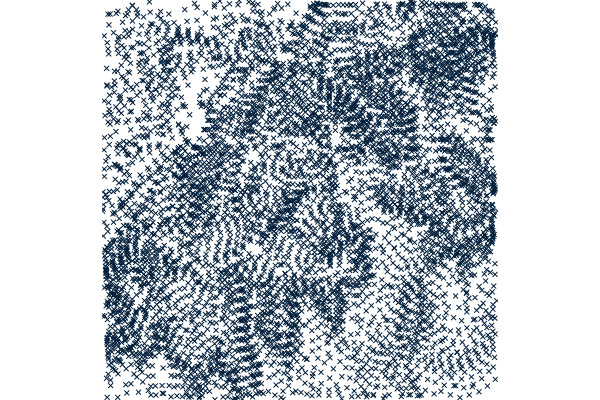

In [5]:
# Set region to the high resolution study area
gs.run_command("g.region", vector="elevations")

# Check out the points
img = gj.GrassRenderer(use_region=True)
img.d_vect(map="elevations")
# Display map
img.show()

### Compute a smooth DEM and extract stream network

#### *Question 1*

Get the basic information about the data, such as number of points, attribute names, and univariate statistics. Display the points with a 1km grid (hint: d.grid) to show the scale of the dataset. What can you tell about the data? Looking at the spatial pattern, how they might have been acquired?

In [ ]:
### Your Answer Here


# Answer
!v.info -c elevations
!v.univar elevations column=VALUE
!d.vect map=elevations where="cat<800" color=grey
!d.vect map=elevations where="VALUE=180" color=brown
!d.vect map=elevations size=1
!d.grid 1000

To compute a histogram of the given data distribution, we can bin the points to 10m resolution grid and then run the histogram. The region is set to match grid created by R spsample function used later on.

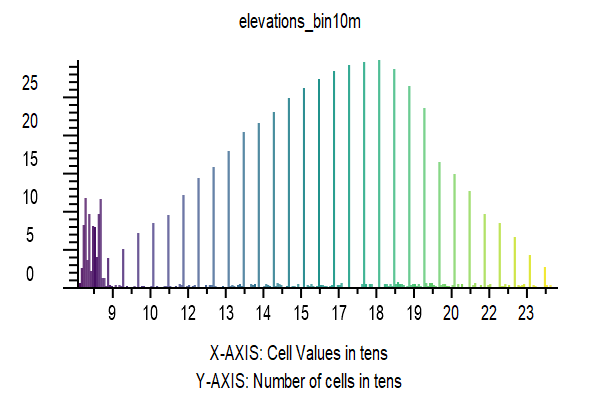

In [7]:
gs.run_command("g.region", n=5074351, s=5070471, e=6555639, w=6551799, res=10, flags="p")
gs.run_command("v.to.rast", input="elevations", out="elevations_bin10m", type="point", use="attr", attr="VALUE")

img = gj.GrassRenderer(use_region=True)
img.d_histogram(map="elevations_bin10m")
img.show()

#### *Question 2*
Can you explain the discrete spikes in the histogram?

In [8]:
#### Your Answer Here

#### *Question 3*

Interpolate a smooth DEM using spline with tension with simultaneous computation of slope, aspect and curvatures
to visualize the surface and its parameters (hint: we computed a smooth DEM from LiDAR points in Assignment 2B). Then, extract the streams using a threshold of 300 and single-flow direction routing. Display the resulting streams (as a vector) and DEM.

Reading features from vector map ...
Ignoring 22 points (too dense)
Processing all selected output files will require
2.30 MB of disk space for temp files.
Processing segments in parallel...
Starting parallel work
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
v.surf.rst complete.
SECTION 1a (of 5): Initiating Memory.
SECTION 1b (of 5): Determining Offmap Flow.
   0   4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68  72  76  80  84  88  92  96 100
SECTION 2: A* Search.
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
SECTION 3a: Accumulating Surface Flow with MFD.
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  

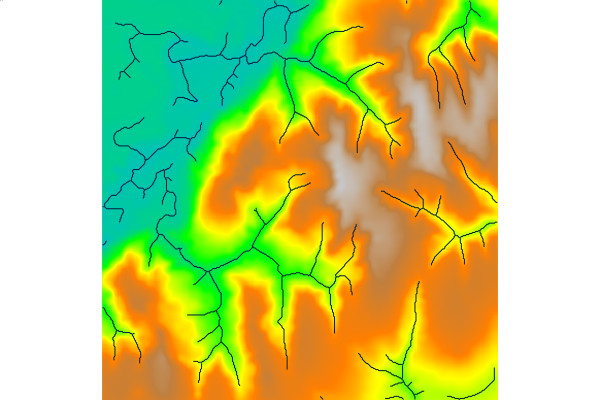

In [9]:
#### Your Answer Here


!v.surf.rst input=elevations zcolumn=VALUE elevation=elevation_10 slope=slope_10 aspect=aspect_10 pcurv=pcurv_10 tcurv=tcurv_10
# !d.histogram elevation_10
!r.watershed elevation=elevation_10 threshold=300 stream=stream10_300 accum=accum10
!r.thin stream10_300 out=stream10_300t --o
!r.to.vect stream10_300t out=stream10_300t type=line
# !d.vect stream10_300t co=blue
img = gj.GrassRenderer(use_region=True)
img.d_rast(map="elevation_10")
img.d_vect(map="stream10_300t")
img.show()

### Estimate the uncertainty in extracted streams

We will estimate uncertainty in the extracted streams
due to errors in elevation using a combination of R and GRASS GIS tools. 

First, we'll need to install the iteractive kernel to run R in Jupyter Notebooks. Here's an example with pip. If you use another python package management system, this may not work for you.

In [ ]:
# This cell needs to be run only once.
!pip install rpy2

After installing the interactive R kernel, we load it.

In [ ]:
%load_ext rpy2.ipython

Now, we can use the `%%R` cell magic. When this cell is interpreted, it's contents will be sent to R. We could also use line magic now with `%R` which would only send the line to R. 

We'll need to install several R packages and download rgrass from github.

In [ ]:
%%R

install.packages(c("rgdal", "gstat", "geoR", "devtools", "IRkernel"))
devtools::install_git("https://github.com/rsbivand/rgrass")

Read in libraries:

In [ ]:
%%R
library(rgrass7)
library(rgdal)
library(gstat)
library(geoR)
use_sp()

Read in elevation vector:

In [14]:
%%R
elevations <- readVECT("elevations")

OGR data source with driver: GPKG 
Source: "C:\Users\caitl\Documents\CourseWork\GIS714_TA\GIS714-assignments\grassdata\baranjahill\HW3_geostat_simulation\.tmp\unknown\181.0.gpkg", layer: "elevations"
with 6367 features
It has 3 fields


Subsample data and explore distribution of values in the data.

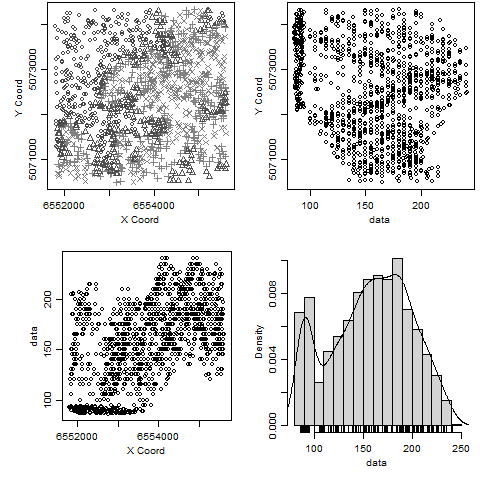

In [15]:
%%R
sel <- runif(length(elevations@data[[2]])) < 0.2
Z.geo <- as.geodata(elevations[sel,"VALUE"])
plot(Z.geo, qt.col=grey(runif(4)))

#### *Question 4*

How many points are subsampled and displayed out of the given 6367? What is the method used for subsampling? What does Density in the histogram mean? Why is the histogram different from the  histograms derived in GRASS GIS?

In [ ]:
#### Your Answer Here

We plot empirical variogram in four directions using the subsampled data, Then we fit 
isotropic model variogram using the Matern covariance function:

variofit: covariance model used is matern 
variofit: weights used: npairs 
variofit: minimisation function used: optim 
variog.env: generating 99 simulations (with  1278 points each) using the function grf
...................................................................................................
variog.env: adding the mean or trend
variog.env: computing the empirical variogram for the 99 simulations
variog.env: computing the envelops


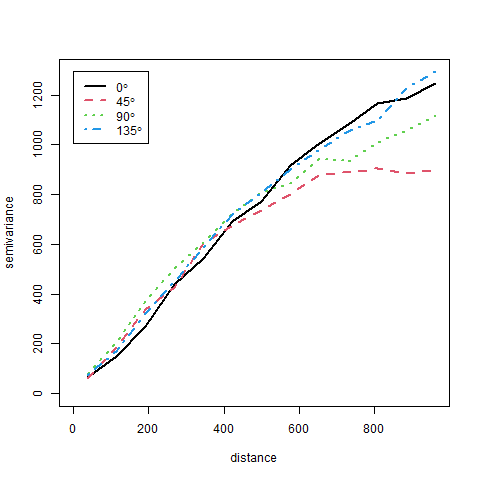

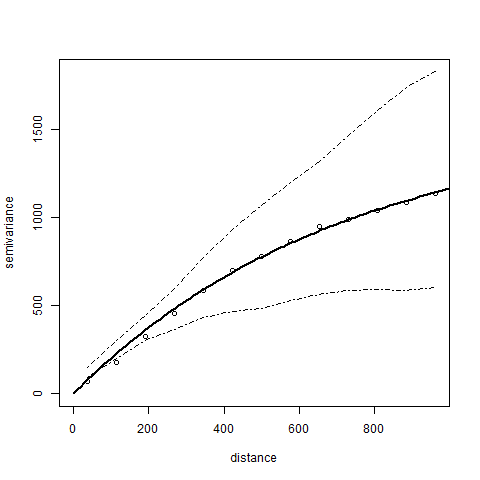

In [16]:
%%R
plot(variog4(Z.geo, max.dist=1000, messages=FALSE), lwd=2)
Z.svar <- variog(Z.geo, max.dist=1000, messages=FALSE)
Z.vgm <- variofit(Z.svar, ini=c(var(Z.geo$data), 1000), fix.nugget=T, nugget=0)
env.model <- variog.model.env(Z.geo, obj.var=Z.svar, model=Z.vgm)
plot(Z.svar, envelope=env.model); lines(Z.vgm, lwd=2);

#### *Question 5*

Why could we use isotropic model variogram? We used max distance 1000, compute the variogram with 3000 and discuss the differences. 
Which max.dist value would you recommend for interpolating or simulating a DEM from our point data set?

In [17]:
#### Your Answer Here.

Compute 100 realizations of a DEM (10m resolution) using Stochastic Conditional Gaussian Simulation
with Matern covariance function (this may take few minutes so be patient). Plot the first 4 simulations.

drawing 100 GLS realisations of beta...
[using conditional Gaussian simulation]


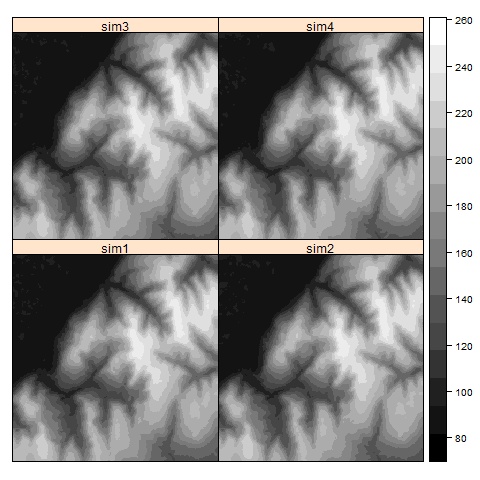

In [18]:
%%R
demgrid <- spsample(elevations, type="regular", cellsize=c(10,10), offset=c(0.5,0.5))
gridded(demgrid) <- TRUE
fullgrid(demgrid) <- TRUE
Z.ovgm <- vgm(psill=Z.vgm$cov.pars[1], model="Mat", range=Z.vgm$cov.pars[2], nugget=Z.vgm$nugget, kappa=1.2)
N.sim <- 100
DEM.sim <- krige(elevations$VALUE ~ 1, elevations, demgrid, Z.ovgm, nmax=30, nsim=N.sim)
fullgrid(DEM.sim) <- TRUE
spplot(DEM.sim[1:4], col.regions=grey(seq(0,1,0.025)))

Save simulated elevation rasters as GRASS rasters, compute a mean simulated DEM and
its standard deviation. Derive streams from each of the simulated DEMs:

In [19]:
%%R
for(i in 1:N.sim) {writeRAST(DEM.sim[i], paste("simulated_", i, sep=""))}

execGRASS("g.list", type="raster", pattern="simulated_*", output="tmp_list_simulated.txt")
execGRASS("r.series", file="tmp_list_simulated.txt", output="simulated_mean", method="average")
execGRASS("r.series", file="tmp_list_simulated.txt", output="simulated_std", method="stddev")

for(i in 1:N.sim) {execGRASS("r.watershed", elevation=paste("simulated_", i, sep=""),
 threshold=30, stream=paste("stream_", i, sep=""), flags=c("quiet"))}

Compute number of streams extracted at each 10m grid cell (count), derive probability that a grid cell
has a stream and associated error map. We'll keep using rgrass here since we need `N.sim`, a variable stored in R.

In [20]:
%%R
execGRASS("g.list", type="raster", pattern="stream*", output="tmp_list_stream.txt")
execGRASS("r.series", file="tmp_list_stream.txt", output="count", method="count")
execGRASS("r.mapcalc", expression=paste("prob = float(count)/", N.sim))
execGRASS("r.mapcalc", expression="error = -prob * log(prob) - (1-prob)* log(1-prob)")

Now, we can switch back to python to visualize and compare our results. Before we do this, you may also want to explore the rasters we created above in the GUI. You can launch the GUI in the command line interface with `g.gui`.

#### *Question 6*

Compare the smooth DEM from question 3 with the simulated mean (`simulated_mean`) and a single realization i=10 (`simulated_10`) (hint: you can copy a color table from one raster to another with r.colors. For example, `r.colors simulated rast=interpolated`). Use aspect to visually compare the roughness of the DEMs and compute the difference between the interpolated and simulated DEM. 

Can you explain the pattern of standard deviations in `simulated_std` (hint: switch on the elevations point layer)?

In [ ]:
#### Your Answer Here

# Answer
!r.colors simulated_mean rast=elevation_10
!r.colors simulated_10 rast=elevation_10
!r.colors simulated_std co=bcyr -e
!r.colors aspect_10 co=aspect
!r.slope.aspect simulated_mean slo=slp_mean asp=asp_mean
!r.slope.aspect simulated_10 slo=slp_10 asp=asp_10
!r.mapcalc "diff_spline_gsim = elevation_10 - simulated_mean"
!r.colors diff_spline_gsim co=differences

#### *Question 7*
Open the GUI and use 3D view to drape the probability raster `prob` over elevation layer `simulated_mean`. Where is the high probability of streams and where we cannot map the streams reliably? Which topographic parameter may explain the stream extraction uncertainty?
How does the stream probability map compare with the streams extracted from the smooth DEM in Question 3?

In [22]:
### Your Answer Here.

### Additional Information
* [Website](https://github.com/ncsu-geoforall-lab/geospatial-simulations-course)
    
* [Computing Help](https://help.ncsu.edu/)
    
* [GIST Home](https://geospatial.ncsu.edu/)
    
* [Disclaimer](https://www.ncsu.edu/policies/prr-disclaimer.php)
    
* [Accessibility](https://oit.ncsu.edu/itaccess)

* License: 2018 [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/)
  
* [NCSU GeoForAll Lab](https://geospatial.ncsu.edu/geoforall/)